In [1]:

import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import time
import scipy
import tqdm
import pydeseq2
from pydeseq2 import utils
from pydeseq2 import grid_search
from pydeseq2.grid_search import grid_fit_alpha

In [2]:
# grid_search

In [3]:
#https://stackoverflow.com/a/49199019
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
            
        yield name


# New version

In [4]:
dds_new=sc.read_h5ad('/home/ec2-user/notebooks/gg2401_sn_13lgs/xist/dds_052.h5ad')
dds_old=sc.read_h5ad('/home/ec2-user/notebooks/gg2401_sn_13lgs/xist/dds_048.h5ad')

In [5]:
dds_new.X

array([[ 1,  2,  1, ...,  1,  0,  0],
       [ 4,  0,  4, ...,  4,  2,  0],
       [10,  8,  5, ...,  7,  7,  2],
       ...,
       [23, 12, 28, ..., 25, 13,  2],
       [36, 12, 27, ..., 12, 14,  4],
       [17,  6, 33, ..., 12,  9,  0]])

new

In [6]:
#https://stackoverflow.com/a/49199019
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))


matplotlib==3.10.3
numpy==2.2.6
pydeseq2==0.5.2
scanpy==1.11.1
scipy==1.15.3
tqdm==4.67.1


old

In [6]:
#https://stackoverflow.com/a/49199019
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))


tqdm==4.67.1
scipy==1.11.4
scanpy==1.9.6
pydeseq2==0.4.8
numpy==1.26.2
matplotlib==3.8.2


In [7]:
min_disp=1e-8
max_disp=dds_old.n_obs
prior_disp_var=None
cr_reg=True
prior_reg=False
optimizer="L-BFGS-B"

#new
non_zero_idx = np.arange(dds_new.n_vars)[dds_new.var["non_zero"]]
counts=dds_new.X[:, non_zero_idx] #this is int
design_matrix=dds_new.obsm['design_matrix'].values #this is float
mu = dds_new.layers['_mu_hat'][:, non_zero_idx]
alpha_hat = dds_new.var["_MoM_dispersions"][dds_new.var["non_zero"]]



In [8]:

x=dds_old.layers['_mu_hat'][:, non_zero_idx][~np.isclose(dds_old.layers['_mu_hat'][:, non_zero_idx],dds_new.layers['_mu_hat'][:, non_zero_idx])]
y=dds_new.layers['_mu_hat'][:, non_zero_idx][~np.isclose(dds_old.layers['_mu_hat'][:, non_zero_idx],dds_new.layers['_mu_hat'][:, non_zero_idx])]




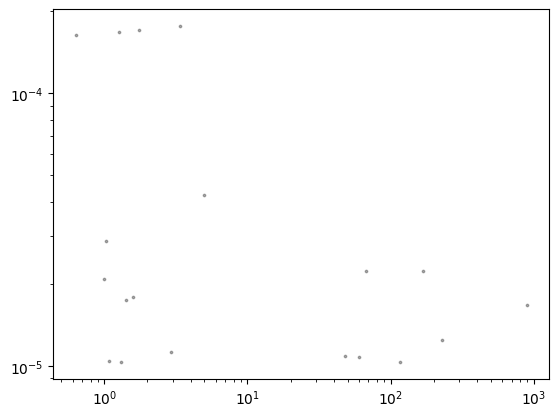

In [9]:
plt.scatter(x,np.abs(y-x)/x,3,'k',alpha=0.3)
plt.xscale('log')
plt.yscale('log')

In [10]:
# assert all(np.arange(dds_new.n_vars)[dds_new.var["non_zero"]]==np.arange(dds_old.n_vars)[dds_old.varm["non_zero"]])
# assert (dds_new.X[:, non_zero_idx]==dds_old.X[:, non_zero_idx]).all()
# assert (dds_old.layers['_mu_hat'][:, non_zero_idx]==dds_new.layers['_mu_hat'][:, non_zero_idx]).all()

In [11]:
x=dds_new.var["_MoM_dispersions"][dds_new.var["non_zero"]][~np.isclose(dds_new.var["_MoM_dispersions"][dds_new.var["non_zero"]],dds_old.varm["_MoM_dispersions"][dds_old.varm["non_zero"]])].values
y=dds_old.varm["_MoM_dispersions"][dds_new.var["non_zero"]][~np.isclose(dds_new.var["_MoM_dispersions"][dds_new.var["non_zero"]],dds_old.varm["_MoM_dispersions"][dds_old.varm["non_zero"]])]

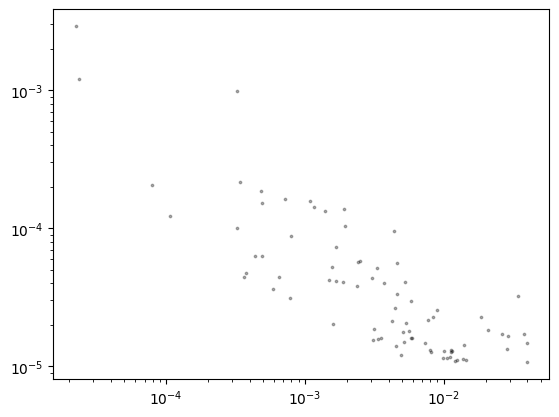

In [12]:
plt.scatter(x,np.abs(y-x)/x,3,'k',alpha=0.3)
plt.xscale('log')
plt.yscale('log')

In [13]:
design_matrix

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 1., 0., 0.],
       [1., 1., 0., 0., 0., 0., 1., 0.],
       [1., 1., 0., 0., 0., 0., 0., 1.]])

In [14]:
# #old
# non_zero_idx = np.arange(dds_old.n_vars)[dds_old.varm["non_zero"]]
# counts=dds_old.X[:, non_zero_idx] #this is float
# # counts=dds_old.X[:, non_zero_idx].astype('float32') #this is float
# # counts=dds_old.X[:, non_zero_idx].astype('float32') #this is float
# # counts=dds_old.X[:, non_zero_idx].astype('int') #this is float
# # counts=dds_old.X[:, non_zero_idx].astype('float32') #this is float
# # counts=dds_old.X[:, non_zero_idx].astype('int') #this is float
# # counts=dds_old.X[:, non_zero_idx]#this is float
# design_matrix=dds_old.obsm['design_matrix'].values #this is int
# # counts=dds_new.X[:, non_zero_idx] #this is int
# # design_matrix=dds_new.obsm['design_matrix'].values.astype(int) #this is float


# mu = dds_old.layers['_mu_hat'][:, non_zero_idx]
# alpha_hat = dds_old.varm["_MoM_dispersions"][dds_old.varm["non_zero"]]


In [15]:
# dds_old.X[:, non_zero_idx].astype(/'float32')[0][0]

In [16]:
# dds_old.X[:, non_zero_idx].astype(float)[0][0]

In [18]:
# (dds_old.X[:, non_zero_idx].astype('float32')==dds_old.X[:, non_zero_idx].astype(float)).mean()

In [19]:
# counts[:,0]+2.3

In [17]:
from scipy.special import gammaln  # type: ignore
from scipy.special import polygamma  # type: ignore

def nb_nll(counts,mu,alpha):

    n = len(counts)
    alpha_neg1 = 1 / alpha
    logbinom = gammaln(counts + alpha_neg1) - gammaln(counts + 1) - gammaln(alpha_neg1)
    if hasattr(alpha, "__len__") and len(alpha) > 1:
        return (
            alpha_neg1 * np.log(alpha)
            - logbinom
            + (counts + alpha_neg1) * np.log(mu + alpha_neg1)
            - (counts * np.log(mu))
        ).sum(0)
    else:
        return (
            n * alpha_neg1 * np.log(alpha)
            + (
                -logbinom
                + (counts + alpha_neg1) * np.log(alpha_neg1 + mu)
                - counts * np.log(mu)
            ).sum()
        )


def dnb_nll(counts,mu,alpha):
    alpha_neg1 = 1 / alpha
    ll_part = (
        alpha_neg1**2
        * (
            polygamma(0, alpha_neg1)
            - polygamma(0, counts + alpha_neg1)
            + np.log(1 + mu * alpha)
            + (counts - mu) / (mu + alpha_neg1)
        ).sum()
    )

    return -ll_part

In [18]:
def fit_alpha_mle(
    counts: np.ndarray,
    design_matrix: np.ndarray,
    mu: np.ndarray,
    alpha_hat: float,
    min_disp: float,
    max_disp: float,
    prior_disp_var,
    cr_reg: bool = True,
    prior_reg: bool = False,
    optimizer = "L-BFGS-B",
) -> tuple[float, bool]:

    assert optimizer in ["BFGS", "L-BFGS-B"]

    if prior_reg:
        # Note: assertion is not working when using numpy
        assert (
            prior_disp_var is not None
        ), "Sigma_prior is required for prior regularization"

    log_alpha_hat = np.log(alpha_hat)

    def loss(log_alpha: float) -> float:
        # closure to be minimized
        alpha = np.exp(log_alpha)
        reg = 0
        if cr_reg:
            W = mu / (1 + mu * alpha)
            reg += 0.5 * np.linalg.slogdet((design_matrix.T * W) @ design_matrix)[1]
        if prior_reg:
            if prior_disp_var is None:
                raise ValueError("Sigma_prior is required for prior regularization")
            reg += (log_alpha - log_alpha_hat) ** 2 / (2 * prior_disp_var)
        return nb_nll(counts, mu, alpha) + reg

    def dloss(log_alpha: float) -> float:
        # gradient closure
        alpha = np.exp(log_alpha)
        reg_grad = 0
        if cr_reg:
            W = mu / (1 + mu * alpha)
            dW = -(W**2)
            reg_grad += (
                0.5
                * (
                    np.linalg.inv((design_matrix.T * W) @ design_matrix)
                    * ((design_matrix.T * dW) @ design_matrix)
                ).sum()
            ) * alpha  # since we want the gradient wrt log_alpha,
            # we need to multiply by alpha
        if prior_reg:
            if prior_disp_var is None:
                raise ValueError("Sigma_prior is required for prior regularization")

            reg_grad += (log_alpha - log_alpha_hat) / prior_disp_var
        # dnb_nll is the gradient wrt alpha, we need to multiply by alpha to get the
        # gradient wrt log_alpha
        return alpha * dnb_nll(counts, mu, alpha) + reg_grad

    res = scipy.optimize.minimize(
        lambda x: loss(x[0]),
        x0=np.log(alpha_hat),
        jac=lambda x: dloss(x[0]),
        method=optimizer,
        bounds=(
            [(np.log(min_disp), np.log(max_disp))] if optimizer == "L-BFGS-B" else None
        ),
    )

    if res.success:
        return np.exp(res.x[0]), res.success
    else:
        return (1e-8,False)



In [19]:
def fit_alpha_mle_with_grid_search(
    counts: np.ndarray,
    design_matrix: np.ndarray,
    mu: np.ndarray,
    alpha_hat: float,
    min_disp: float,
    max_disp: float,
    prior_disp_var,
    cr_reg: bool = True,
    prior_reg: bool = False,
    optimizer = "L-BFGS-B",return_everything=False
) -> tuple[float, bool]:

    assert optimizer in ["BFGS", "L-BFGS-B"]

    if prior_reg:
        # Note: assertion is not working when using numpy
        assert (
            prior_disp_var is not None
        ), "Sigma_prior is required for prior regularization"

    log_alpha_hat = np.log(alpha_hat)

    def loss(log_alpha: float) -> float:
        # closure to be minimized
        alpha = np.exp(log_alpha)
        reg = 0
        if cr_reg:
            W = mu / (1 + mu * alpha)
            reg += 0.5 * np.linalg.slogdet((design_matrix.T * W) @ design_matrix)[1]
        if prior_reg:
            if prior_disp_var is None:
                raise ValueError("Sigma_prior is required for prior regularization")
            reg += (log_alpha - log_alpha_hat) ** 2 / (2 * prior_disp_var)
        return nb_nll(counts, mu, alpha) + reg

    def dloss(log_alpha: float) -> float:
        # gradient closure
        alpha = np.exp(log_alpha)
        reg_grad = 0
        if cr_reg:
            W = mu / (1 + mu * alpha)
            dW = -(W**2)
            reg_grad += (
                0.5
                * (
                    np.linalg.inv((design_matrix.T * W) @ design_matrix)
                    * ((design_matrix.T * dW) @ design_matrix)
                ).sum()
            ) * alpha  # since we want the gradient wrt log_alpha,
            # we need to multiply by alpha
        if prior_reg:
            if prior_disp_var is None:
                raise ValueError("Sigma_prior is required for prior regularization")

            reg_grad += (log_alpha - log_alpha_hat) / prior_disp_var
        # dnb_nll is the gradient wrt alpha, we need to multiply by alpha to get the
        # gradient wrt log_alpha
        return alpha * dnb_nll(counts, mu, alpha) + reg_grad

    res = scipy.optimize.minimize(
        lambda x: loss(x[0]),
        x0=np.log(alpha_hat),
        jac=lambda x: dloss(x[0]),
        method=optimizer,
        bounds=(
            [(np.log(min_disp), np.log(max_disp))] if optimizer == "L-BFGS-B" else None
        ),
    )
    grid_res = grid_fit_alpha(counts, design_matrix, mu, alpha_hat, min_disp, max_disp)
    grid_loss = loss(grid_res)
    # print(res)
    lbfgsb_res = res.x[0]
    lbfgsb_converged=res.success
    lbfgsb_loss = loss(lbfgsb_res)

    if return_everything:
        return grid_res, grid_loss, lbfgsb_res,lbfgsb_loss, lbfgsb_converged
    if res.success:
        return np.exp(res.x[0]), res.success
    else:
        return np.exp(grid_res), res.success



In [20]:
def plot_loss(counts: np.ndarray,
    design_matrix: np.ndarray,
    mu: np.ndarray,
    alpha_hat: float,
    min_disp: float,
    max_disp: float,
    prior_disp_var,
    cr_reg: bool = True,
    prior_reg: bool = False,
    optimizer = "L-BFGS-B",
):
    if prior_reg:
        # Note: assertion is not working when using numpy
        assert (
            prior_disp_var is not None
        ), "Sigma_prior is required for prior regularization"

    log_alpha_hat = np.log(alpha_hat)

    def loss(log_alpha: float) -> float:
        # closure to be minimized
        alpha = np.exp(log_alpha)
        reg = 0
        if cr_reg:
            W = mu / (1 + mu * alpha)
            reg += 0.5 * np.linalg.slogdet((design_matrix.T * W) @ design_matrix)[1]
        if prior_reg:
            if prior_disp_var is None:
                raise ValueError("Sigma_prior is required for prior regularization")
            reg += (log_alpha - log_alpha_hat) ** 2 / (2 * prior_disp_var)
        return nb_nll(counts, mu, alpha) + reg
    def dloss(log_alpha: float) -> float:
        # gradient closure
        alpha = np.exp(log_alpha)
        reg_grad = 0
        if cr_reg:
            W = mu / (1 + mu * alpha)
            dW = -(W**2)
            reg_grad += (
                0.5
                * (
                    np.linalg.inv((design_matrix.T * W) @ design_matrix)
                    * ((design_matrix.T * dW) @ design_matrix)
                ).sum()
            ) * alpha  # since we want the gradient wrt log_alpha,
            # we need to multiply by alpha
        if prior_reg:
            if prior_disp_var is None:
                raise ValueError("Sigma_prior is required for prior regularization")

            reg_grad += (log_alpha - log_alpha_hat) / prior_disp_var
        # dnb_nll is the gradient wrt alpha, we need to multiply by alpha to get the
        # gradient wrt log_alpha
        return alpha * dnb_nll(counts, mu, alpha) + reg_grad

    res = scipy.optimize.minimize(
        lambda x: loss(x[0]),
        x0=np.log(alpha_hat),
        jac=lambda x: dloss(x[0]),
        method=optimizer,
        bounds=(
            [(np.log(min_disp), np.log(max_disp))] if optimizer == "L-BFGS-B" else None
        ),
    )
    print(res.message)
    print(res.success)
    print('lbfgsb ' + str(res.x[0]))
    print('lbfgsb ' + str(res.x[0]+1e-4))
    # print( np.exp(res.x[0]))
    # print(alpha_hat)
    xl = np.linspace(np.log(min_disp), np.log(max_disp),500)
    plt.plot(xl,[loss(x_) for x_ in xl],color='lightgray',zorder=-1000)
    plt.scatter(np.log(alpha_hat),loss(np.log(alpha_hat)),120,'k',marker='^',label='start '+str(loss(np.log(alpha_hat))))
    plt.scatter(res.x[0],loss(res.x[0]),60,'r',label='lbfgsb '+str(loss(res.x[0])))
    # x_ = -2.6546317340695693
    # print(loss(-20))
    # print(loss(-15))
    # print(loss(-10))
    x_=grid_fit_alpha(counts, design_matrix, mu, alpha_hat, min_disp, max_disp)
    print('grid '+str(x_))
    # print(x_)
    plt.scatter(x_,loss(x_),30,'b',label='grid '+str(loss(x_)) )
    plt.legend()
    plt.xlabel('log alpha')
    plt.ylabel('loss')
    # print(loss(x_))
    # plt.yscale('log')

In [21]:
# design_matrix_=np.array([[1., 0., 0., 0., 0., 0., 0., 0.],
#        [1., 0., 0., 0., 1., 0., 0., 0.],
#        [1., 0., 1., 0., 0., 0., 0., 0.],
#        [1., 0., 0., 1., 0., 0., 0., 0.],
#        [1., 0., 0., 0., 0., 1., 0., 0.],
#        [1., 0., 0., 0., 0., 0., 1., 0.],
#        [1., 0., 0., 0., 0., 0., 0., 1.],
#        [1., 1., 0., 0., 0., 0., 0., 0.],
#        [1., 1., 0., 0., 1., 0., 0., 0.],
#        [1., 1., 1., 0., 0., 0., 0., 0.],
#        [1., 1., 0., 1., 0., 0., 0., 0.],
#        [1., 1., 0., 0., 0., 1., 0., 0.],
#        [1., 1., 0., 0., 0., 0., 1., 0.],
#        [1., 1., 0., 0., 0., 0., 0., 1.]])
# counts_ = np.array([ 1,  4,  5,  1,  6, 12,  6,  0,  6, 11,  3, 28, 27, 33])
# mu _ = np.array([ 0.48002107,  1.90728713,  8.34361091,  1.37591092,  7.51619853,
#         7.98984003,  7.38754112,  0.52039459,  8.09271187,  7.65638792,
#         2.62408874, 26.48380025, 31.01015974, 31.61245707])

/tmp/ipykernel_25972/1777447424.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_hat = alpha_hat[i],


CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
True
lbfgsb -18.420633954354834
lbfgsb -18.420533954354834
grid -2.2471628906982564


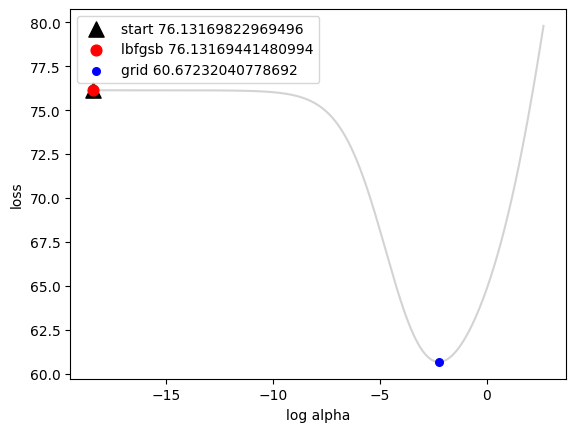

In [49]:
i = 2875
plot_loss(
                                 # counts=counts[:,i].astype('float32'),
                                 counts=counts[:,i].astype('int'),
                                 design_matrix=design_matrix,
                                 mu=mu[:,i],
                                 # alpha_hat=np.exp((np.log(min_disp)+np.log(max_disp))/2),
                                 alpha_hat = alpha_hat[i],
                                 min_disp=min_disp,
                                 max_disp=max_disp,
                                 prior_disp_var=prior_disp_var,
                                 cr_reg=cr_reg,
                                 prior_reg=prior_reg,
                                 optimizer=optimizer)

This oscillation is very poorly reproducible... need float32 + older version?

/tmp/ipykernel_25972/4132136430.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_hat = alpha_hat[i],


ABNORMAL_TERMINATION_IN_LNSRCH
False
lbfgsb -7.712728086274476
lbfgsb -7.712628086274476
grid -17.485981625290812


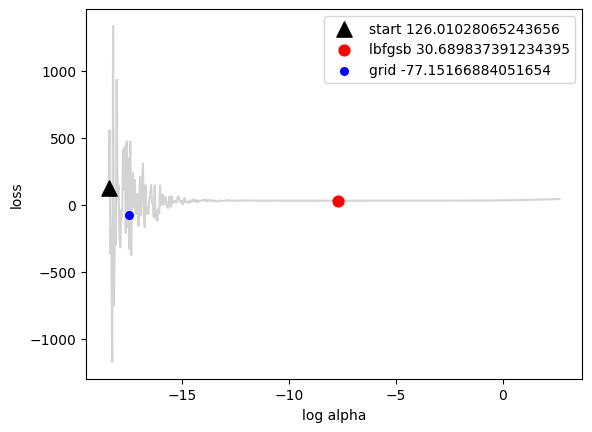

In [24]:
i = 1
plot_loss(
                                 counts=counts[:,i].astype('float32'),
                                 # counts=counts[:,i].astype('int'),
                                 design_matrix=design_matrix,
                                 mu=mu[:,i],
                                 # alpha_hat=np.exp((np.log(min_disp)+np.log(max_disp))/2),
                                 alpha_hat = alpha_hat[i],
                                 min_disp=min_disp,
                                 max_disp=max_disp,
                                 prior_disp_var=prior_disp_var,
                                 cr_reg=cr_reg,
                                 prior_reg=prior_reg,
                                 optimizer=optimizer)

In [25]:
counts[:,i].astype('int')

array([ 2,  0,  8,  1,  4,  6,  0,  1,  1,  5,  6, 12, 12,  6])

In [26]:
gf = ~dds_old.varm['_genewise_converged']

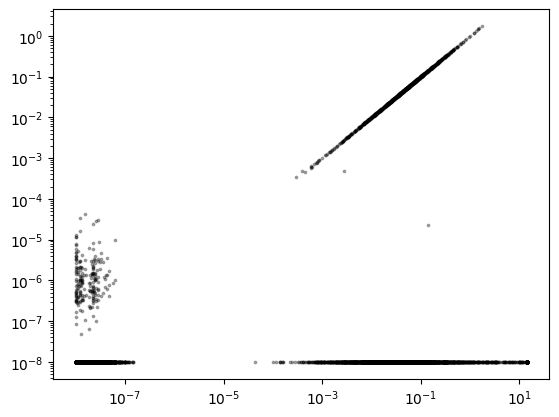

In [27]:
plt.scatter(dds_old.varm['genewise_dispersions'][gf],dds_new.var['genewise_dispersions'][gf],3,'k',alpha=0.3)
plt.xscale('log')
plt.yscale('log')

In [28]:
dds_old.varm['genewise_dispersions'][non_zero_idx][:10]

array([2.11859802e-02, 5.26979691e-04, 7.03247321e-02, 5.84462092e-02,
       8.01104056e-02, 1.62517223e-08, 4.15975804e-02, 2.42571124e-02,
       7.55949851e-02, 2.18145110e-08])

In [29]:
dds_new.var['genewise_dispersions'][non_zero_idx].values[:10]

/tmp/ipykernel_25972/262517294.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dds_new.var['genewise_dispersions'][non_zero_idx].values[:10]


array([2.11604610e-02, 1.00000000e-08, 1.00000000e-08, 5.84452975e-02,
       1.00000000e-08, 1.00000000e-08, 4.15490185e-02, 1.00000000e-08,
       1.00000000e-08, 1.00000000e-08])

In [30]:
dds_new.var['_genewise_converged'][non_zero_idx][:10].values

/tmp/ipykernel_25972/2433993565.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dds_new.var['_genewise_converged'][non_zero_idx][:10].values


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [31]:
dds_old.varm['_genewise_converged'][non_zero_idx][:10]

array([False,  True,  True,  True, False, False, False, False, False,
       False])

In [32]:

N=len(non_zero_idx)
grid_res, grid_loss, lbfgsb_res,lbfgsb_loss,lbfgsb_conv = [np.empty(N) for i in range(5)]
# res=np.empty(N)
# conv=np.empty(N)
for i in tqdm.tqdm(range(N)):
    # r = fit_alpha_mle(
    r = fit_alpha_mle_with_grid_search(
                                     # counts=counts[:,i].astype('float32'),
                                     counts=counts[:,i].astype('int'),
                                     design_matrix=design_matrix,
                                     mu=mu[:,i],
                                     alpha_hat = alpha_hat[i],
                                     min_disp=min_disp,
                                     max_disp=max_disp,
                                     prior_disp_var=prior_disp_var,
                                     cr_reg=cr_reg,
                                     prior_reg=prior_reg,
                                     optimizer=optimizer,return_everything=True)
    grid_res[i], grid_loss[i], lbfgsb_res[i],lbfgsb_loss[i],lbfgsb_conv[i] = r
    # res[i] = r[0]
    # conv[i] = r[1]
    

  0%|                                                                                                                         | 0/10390 [00:00<?, ?it/s]/tmp/ipykernel_25972/1286205508.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_hat = alpha_hat[i],
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10390/10390 [01:56<00:00, 88.93it/s]


In [33]:
grid_loss[grid_loss<0]

array([-5.15525043, -0.14378774, -0.68587327, -5.19895094, -5.19895094,
       -2.0601235 , -5.1444304 , -5.19861021, -1.3344541 , -0.6633254 ,
       -1.39928435, -0.82151244, -5.19500253, -0.95889593, -0.82725909,
       -1.3960247 , -2.08499692, -5.16317856, -2.00425783, -1.50975056,
       -1.39247099, -0.67671144, -2.19439395, -4.46660585, -2.07492454,
       -2.03573549, -2.07492454, -0.42621688, -2.10648518])

Text(0, 0.5, 'lbfgsb loss less search loss')

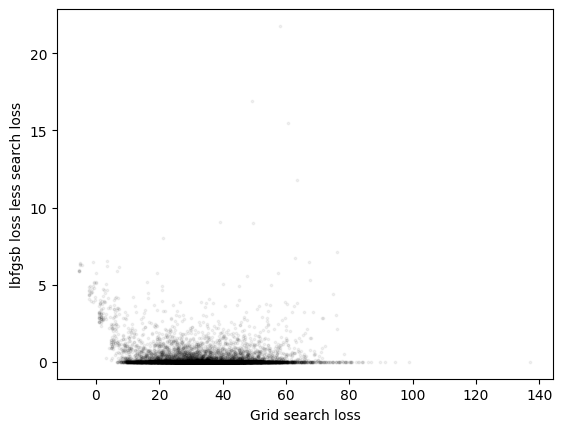

In [34]:
plt.scatter(grid_loss,lbfgsb_loss-grid_loss,3,'k',alpha=0.05)
xl=[0,154]
plt.xlabel('Grid search loss')
plt.ylabel('lbfgsb loss less search loss')

In [35]:
dds_old.varm['_genewise_converged']

array([False,  True,  True, ..., False, False, False])

In [38]:
# (df['lbfgsb_conv']==dds_old.varm['_genewise_converged'][non_zero_idx]).mean()

In [39]:
import pandas as pd 

df = pd.DataFrame.from_dict({'grid_res':grid_res, 'grid_loss':grid_loss, 'lbfgsb_res':lbfgsb_res,'lbfgsb_loss':lbfgsb_loss,'lbfgsb_conv':lbfgsb_conv})



                             

In [40]:
df['diff']=df['lbfgsb_loss']-df['grid_loss']

In [41]:
df['lbfgsb_loss']<df['grid_loss']

0         True
1        False
2        False
3         True
4        False
         ...  
10385    False
10386    False
10387     True
10388    False
10389    False
Length: 10390, dtype: bool

In [42]:
lbfgsb_conv.mean()

0.9994225216554379

In [43]:
df.loc[df['lbfgsb_loss']<df['grid_loss'],'lbfgsb_loss']

0        40.628063
3        51.655500
6        59.823137
12       34.181656
13       40.372278
           ...    
10361    40.635539
10364    36.412928
10374    55.821732
10383    29.074470
10387    36.927256
Name: lbfgsb_loss, Length: 2175, dtype: float64

In [44]:
df['best_result'] = None
df.loc[df['lbfgsb_loss']<df['grid_loss'],'best_result'] = df.loc[df['lbfgsb_loss']<df['grid_loss'],'lbfgsb_res']
df.loc[df['lbfgsb_loss']>=df['grid_loss'],'best_result'] = df.loc[df['lbfgsb_loss']>=df['grid_loss'],'grid_res']
df['best_result']=df['best_result'].astype(float)

In [45]:
df.sort_values('diff',ascending=False)

,grid_res,grid_loss,lbfgsb_res,lbfgsb_loss,lbfgsb_conv,diff,best_result
7990,-1.344695,57.991126,-18.420681,79.765196,0.0,21.774069,-1.344695
7275,-1.361885,49.281832,-18.420681,66.221080,0.0,16.939248,-1.361885
2875,-2.247163,60.672320,-18.420634,76.131694,1.0,15.459374,-2.247163
2060,-2.616745,63.585314,-18.420681,75.405020,1.0,11.819706,-2.616745
5962,-0.762388,39.183937,-18.420681,48.271769,1.0,9.087832,-0.762388
...,...,...,...,...,...,...,...
8444,-17.485982,46.519728,-18.420681,46.519722,1.0,-0.000006,-18.420681
8771,-16.968137,35.338073,-18.420681,35.338067,1.0,-0.000006,-18.420681
5456,-18.225146,39.228249,-18.420681,39.228241,1.0,-0.000008,-18.420681
4500,-18.238038,22.793321,-18.420681,22.793313,1.0,-0.000008,-18.420681


In [47]:
# plt.scatter(dds_old.varm['genewise_dispersions'][non_zero_idx][conv],res[conv],3,'k',alpha=0.05)
# plt.scatter(dds_old.varm['genewise_dispersions'][non_zero_idx][~conv],res[~conv],3,'lightgray',alpha=0.05)
# plt.xscale('log')
# plt.yscale('log')

The potentially interesting genes are where lbfgsb_conv=1 i.e. lbfgsb converges but the grid loss is still lower than the lbfgsb loss

In [48]:
df[df['lbfgsb_conv']==1].sort_values('diff',ascending=False)[:20]

,grid_res,grid_loss,lbfgsb_res,lbfgsb_loss,lbfgsb_conv,diff,best_result
2875,-2.247163,60.672320,-18.420634,76.131694,1.0,15.459374,-2.247163
2060,-2.616745,63.585314,-18.420681,75.405020,1.0,11.819706,-2.616745
5962,-0.762388,39.183937,-18.420681,48.271769,1.0,9.087832,-0.762388
1435,-1.591799,49.532863,-18.420681,58.521661,1.0,8.988798,-1.591799
7163,0.943707,21.108554,-18.420681,29.165621,1.0,8.057066,0.943707
8360,-3.587973,76.219839,-18.420668,83.339582,1.0,7.119744,-3.587973
8339,2.851782,3.427825,-18.420681,9.984729,1.0,6.556903,2.851782
4775,2.851782,-0.958896,-18.420681,5.548580,1.0,6.507476,2.851782
2124,2.851782,-5.144430,-18.420681,1.258906,1.0,6.403336,2.851782
368,2.851782,-5.155250,-18.420681,1.160005,1.0,6.315255,2.851782
